<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/2020-01-embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embeddings with TensorFlow 2

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [0]:
seed = 42

In [0]:
import numpy as np
np.random.seed(seed)

In [5]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

In [0]:
tf.random.set_seed(seed)

In [7]:
!nvidia-smi

Thu Feb 13 09:55:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

In [0]:
from lrcurve import KerasLearningCurve

## Airline Embeddings

_Basic assumption: airlines fliying similar routes are similar_

### Data Sets
* Single Flights: http://stat-computing.org/dataexpo/2009/the-data.html
* Routes between airports: https://openflights.org/data.html#route


In [10]:
!curl -O https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2321k  100 2321k    0     0  5789k      0 --:--:-- --:--:-- --:--:-- 5774k


In [11]:
import pandas as pd

df = pd.read_csv('routes.dat', quotechar="'", sep=',', encoding='utf-8', header=None, na_values='\\N',
                names=['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'])

# https://openflights.org/data.html#route
  
# Airline	2-letter (IATA) or 3-letter (ICAO) code of the airline.
# Airline ID	Unique OpenFlights identifier for airline (see Airline).
# Source airport	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
# Source airport ID	Unique OpenFlights identifier for source airport (see Airport)
# Destination airport	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
# Destination airport ID	Unique OpenFlights identifier for destination airport (see Airport)
# Codeshare	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
# Stops	Number of stops on this flight ("0" for direct)
# Equipment	3-letter codes for plane type(s) generally used on this flight, separated by spaces

# df[df['Stops'] == 1] gives only a dozen or so routes, so also drop it
df.drop(['Airline ID',	'Source airport ID', 'Destination airport ID', 'Codeshare', 'Equipment', 'Stops'], axis='columns', inplace=True)
len(df)

67663

In [12]:
df.head()

,Airline,Source airport,Destination airport
0,2B,AER,KZN
1,2B,ASF,KZN
2,2B,ASF,MRV
3,2B,CEK,KZN
4,2B,CEK,OVB


In [13]:
sources = df['Source airport'].unique()
len(sources)

3409

In [14]:
destinations = df['Destination airport'].unique()
len(destinations)

3418

In [15]:
airlines = df['Airline'].unique()
len(airlines)

568

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer

airline_tokenizer = Tokenizer()
airline_tokenizer.fit_on_texts(df['Airline'])

import numpy as np

encoded_airlines = np.array(airline_tokenizer.texts_to_sequences(df['Airline'])).reshape(-1)
encoded_airlines

array([241, 241, 241, ..., 543, 543, 543])

In [17]:
routes = df[['Source airport', 'Destination airport']].apply(lambda x: ' '.join(x), axis=1)
routes.head()

0    AER KZN
1    ASF KZN
2    ASF MRV
3    CEK KZN
4    CEK OVB
dtype: object

In [0]:
routes_tokenizer = Tokenizer()
routes_tokenizer.fit_on_texts(routes)
encoded_routes = np.array(routes_tokenizer.texts_to_sequences(routes))

In [19]:
# should be a bit more 3400 as source and destination are from the same set
output_dim = len(routes_tokenizer.word_index) + 1
output_dim

3426

In [20]:
encoded_routes[0]

array([511, 491])

In [0]:
# sequence of airlines encoded as a unique number
x = encoded_airlines
# sequence of pair, src, dest encoded as a unique numbers
Y = encoded_routes

## 2d embeddings

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, GlobalAveragePooling1D, Dense, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, RepeatVector
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.initializers import glorot_normal

input_dim = len(airlines) + 1
embedding_dim = 2

model = Sequential()

model.add(Embedding(name='embedding',
                    input_dim=input_dim, 
                    output_dim=embedding_dim, 
                    input_length=1,
                    embeddings_initializer=glorot_normal(seed=seed)))

# https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras
# averages over all (global) embedding values 
# model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.add(Dense(units=50, activation='relu', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))

model.add(RepeatVector(2))

model.add(SimpleRNN(units=50, return_sequences=True, bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))

model.add(Dense(units=output_dim, name='output', activation='softmax', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 2)              1138      
_________________________________________________________________
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 50)                150       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 50)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 2, 50)             5050      
_________________________________________________________________
output (Dense)               (None, 2, 3426)           174726    
Total params: 181,064
Trainable params: 181,064
Non-trainable params: 0
__________________________________________________

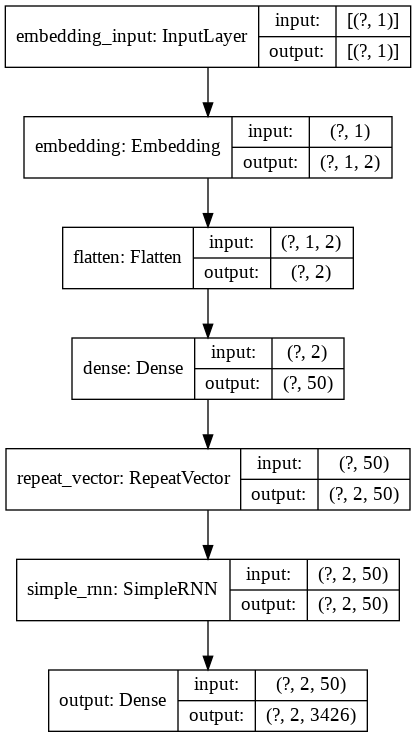

In [23]:
from tensorflow.keras.utils import plot_model, model_to_dot

plot_model(model, show_shapes=True)

In [24]:
%%time

BATCH_SIZE = 2048
EPOCHS = 75

history = model.fit(x, Y, 
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 24.9 s, sys: 3.55 s, total: 28.5 s
Wall time: 1min 10s


In [25]:
loss, accuracy = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss, accuracy

67663/67663 [==============================] - 1s 9us/sample - loss: 4.5537 - accuracy: 0.1373


(4.5537104513745845, 0.13734242)

In [26]:
# https://en.wikipedia.org/wiki/List_of_airline_codes
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_Europe

europe_airlines = ['LH', 'BA', 'SK', 'KL', 'AF', 'FR', 'SU', 'EW', 'TP', 'BT', 'U2']
us_airlines = ['AA', 'US', 'UA', 'WN', 'DL', 'AS', 'HA']

samples = [airline_tokenizer.word_index[airline_code.lower()] for airline_code in europe_airlines + us_airlines]
samples

[12, 23, 26, 15, 11, 1, 28, 568, 75, 129, 10, 2, 5, 3, 9, 4, 25, 183]

In [27]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_2d = embedding_model.predict(samples).reshape(-1, 2)
embeddings_2d.shape

(18, 2)

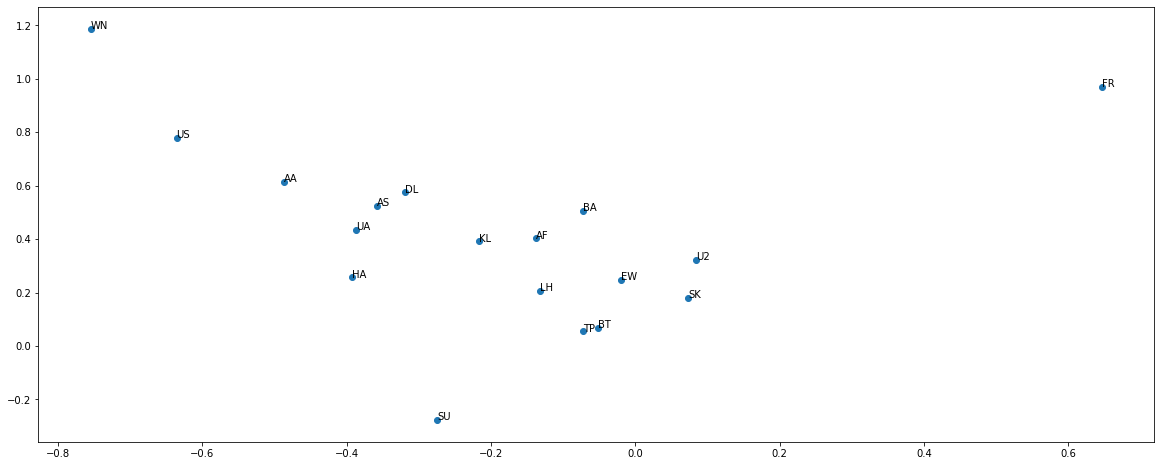

In [28]:
# plt.axis('off')

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for index, x_pos, y_pos in zip(samples, embeddings_2d[:, 0], embeddings_2d[:, 1]):
  name = airline_tokenizer.index_word[index].upper()
  plt.annotate(name, (x_pos, y_pos))

## 1d embeddings

In [0]:
input_dim = len(airlines) + 1
embedding_dim = 1

model = Sequential()

model.add(Embedding(name='embedding',
                    input_dim=input_dim, 
                    output_dim=embedding_dim, 
                    input_length=1,
                   embeddings_initializer=glorot_normal(seed=seed)))

# model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.add(Dense(units=50, activation='relu', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))

model.add(RepeatVector(2))

model.add(SimpleRNN(units=50, return_sequences=True, bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))

model.add(Dense(units=output_dim, name='output', activation='softmax', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model.summary()

In [30]:
%%time

BATCH_SIZE = 2048
EPOCHS = 75

history = model.fit(x, Y, 
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 24 s, sys: 3.5 s, total: 27.5 s
Wall time: 1min 9s


In [31]:
# we expect this to be substantially worse than the 2d version as the bottle neck now is much more narrow
loss, accuracy = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss, accuracy

67663/67663 [==============================] - 1s 9us/sample - loss: 5.0526 - accuracy: 0.0761


(5.052554543797096, 0.076127276)

In [32]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_1d = embedding_model.predict(samples).reshape(-1)
embeddings_1d.shape

(18,)

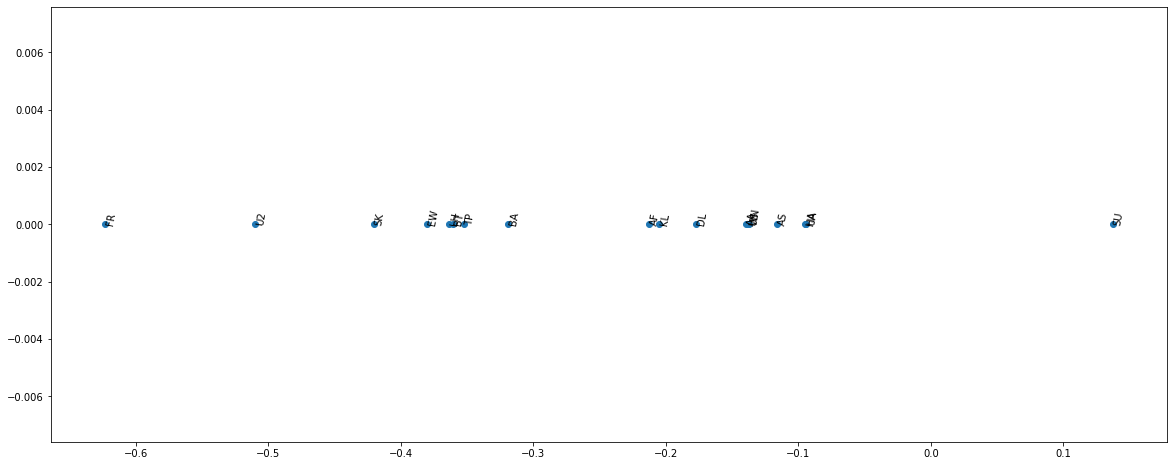

In [33]:
# plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
for index, x_pos in zip(samples, embeddings_1d):
  name = airline_tokenizer.index_word[index].upper()
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, 0), rotation=80)

## Clustering in 2d

1d embedding vs size of airline
* find what is similar
* what is an outlier

In [0]:
# https://en.wikipedia.org/wiki/List_of_airline_codes
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America
# https://www.tvlon.com/resources/airlinecodes.htm
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_Europe

airline_size = {
    'LH': 130, 'BA': 105, 'SK': 30, 'KL': 101, 'AF': 101, 'FR': 129, 'SU': 56, 'EW': 24, 'TP': 16, 'BT': 4, 'U2': 88, 'AA': 204, 'US': 204, 'UA': 158, 'WN': 164, 'DL': 192, 'AS': 46, 'HA': 12
}
sample_names = [airline_tokenizer.index_word[sample].upper() for sample in samples]
sample_sizes = [airline_size[name] * 1e6 for name in sample_names]

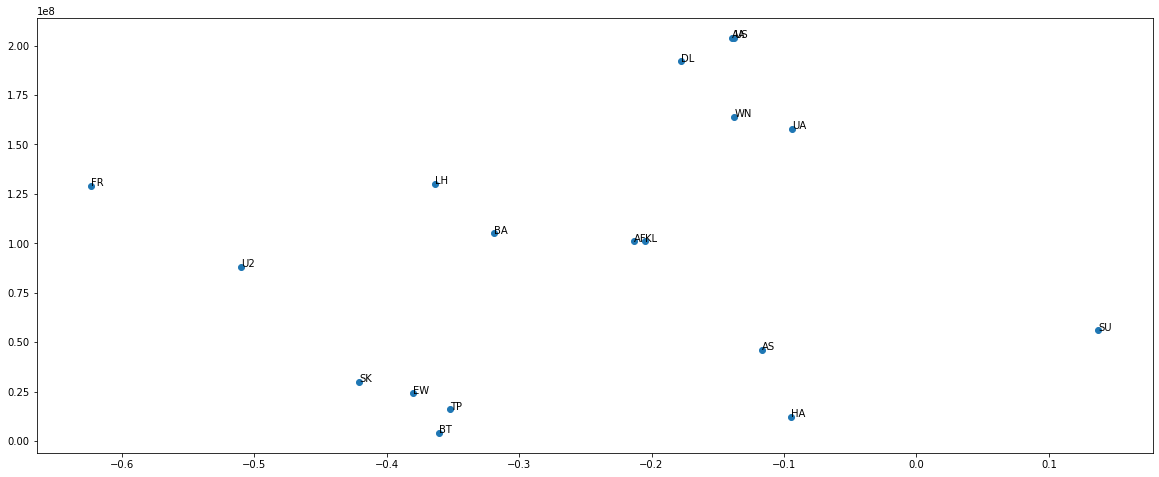

In [35]:
plt.scatter(embeddings_1d, sample_sizes)
for name, x_pos, y_pos in zip(sample_names, embeddings_1d, sample_sizes):
  plt.annotate(name, (x_pos,  y_pos))

In [36]:
from sklearn.preprocessing import StandardScaler

embeddings_1d_scaled = StandardScaler().fit_transform(embeddings_1d.reshape(-1, 1))
sizes_for_samples_scaled = StandardScaler().fit_transform(np.array(sample_sizes).reshape(-1, 1))
X = np.dstack((embeddings_1d_scaled.reshape(-1), sizes_for_samples_scaled.reshape(-1)))[0]
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[-0.64317727,  0.48321195],
       [-0.38974402,  0.10570261],
       [-0.96871405, -1.0268254 ],
       [ 0.25869607,  0.04530112],
       [ 0.21290462,  0.04530112],
       [-2.12189672,  0.46811158],
       [ 2.20639058, -0.63421569],
       [-0.73850024, -1.11742764],
       [-0.58047599, -1.23823063],
       [-0.6279605 , -1.41943512],
       [-1.47708069, -0.15100374],
       [ 0.63169698,  1.6006396 ],
       [ 0.63986735,  1.6006396 ],
       [ 0.8904836 ,  0.90602241],
       [ 0.64278613,  0.99662466],
       [ 0.41570746,  1.41943512],
       [ 0.76256178, -0.78521943],
       [ 0.88645492, -1.29863213]])

In [41]:
%%time

from sklearn.cluster import DBSCAN

clf = DBSCAN(eps=1.0, min_samples=2)
clf.fit(X_scaled)
clusters = clf.labels_.astype(np.int)
clusters

CPU times: user 1.92 ms, sys: 120 µs, total: 2.04 ms
Wall time: 1.72 ms


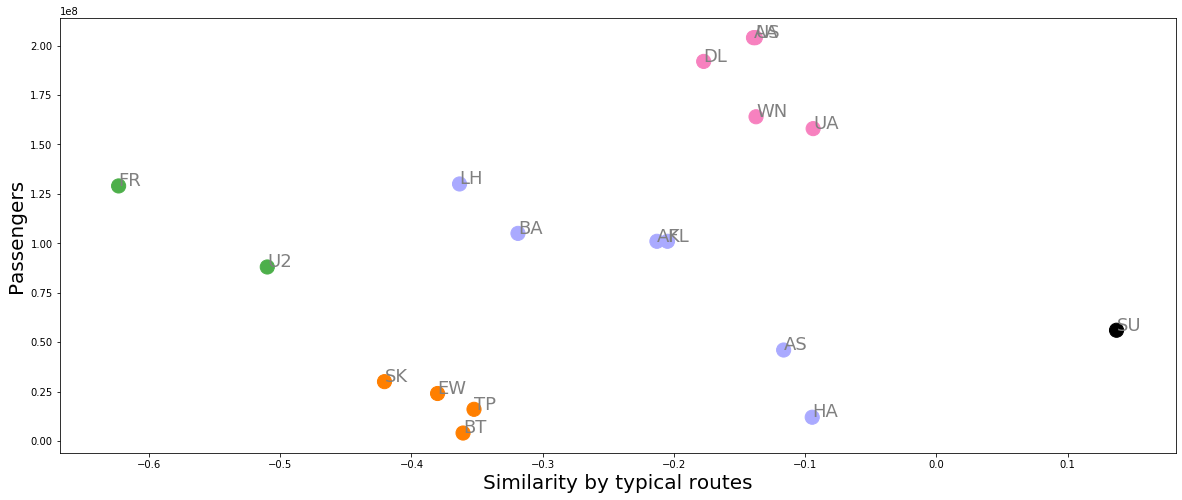

In [42]:
import matplotlib.pyplot as plt

from itertools import cycle, islice

# last color is black to properly display label -1 as noise (black)
colors = np.append(np.array(list(islice(cycle(['#AAAAFF', '#ff7f00', '#4daf4a',
                                 '#f781bf', '#a65628', '#984ea3',
                                 '#999999', '#e41a1c', '#dede00']),
                          int(max(clusters) + 1)))), ['#000000'])

# plt.figure(dpi=600)

plt.xlabel('Similarity by typical routes')
plt.ylabel('Passengers')

plt.scatter(embeddings_1d, sample_sizes, color=colors[clusters], s=200)
for name, x_pos, y_pos in zip(sample_names, embeddings_1d, sample_sizes):
  plt.annotate(name, (x_pos,  y_pos), fontsize=18, color='grey')
